# SLEI Research Data Task - Comprehensive Analysis  
**Candidate:** Surya Doddipatla  
**Position:** Research Analyst - Stanford Latino Entrepreneurship Initiative  

## Executive Summary

This analysis demonstrates advanced data analysis capabilities directly applicable to SLEI's mission of understanding Latino entrepreneurship patterns. Through baseball data, I showcase the analytical approaches needed for Dr. Zárate's research: international talent analysis, temporal trend identification, data infrastructure design, and evidence-based policy recommendations. Each component directly parallels challenges in studying Latino business success factors, geographic entrepreneurship patterns, and international talent development.

# Q1: Hall of Fame Players by Country Over Time
**Strategic Approach & SLEI Relevance**

This analysis mirrors SLEI's core work: tracking how international talent (Latino entrepreneurs) achieves recognition (business success) over time across different regions. The methodological framework directly transfers to analyzing Latino business ownership patterns, venture capital access by country of origin, and entrepreneurship success trajectories.

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [117]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [118]:
def load_and_validate_data():
    
    try:
        
        people = pd.read_csv('/Users/suryad/Documents/Surya/Assessment/Data Task Files/People.csv', encoding='latin-1')
        hall_of_fame = pd.read_csv('/Users/suryad/Documents/Surya/Assessment/Data Task Files/HallOfFame.csv', encoding='latin-1')
        
        # Data quality validation
        print("Data Quality Assessment:")
        print(f"People records: {len(people):,}")
        print(f"Hall of Fame records: {len(hall_of_fame):,}")
        print(f"Missing birth countries: {people['birthCountry'].isna().sum():,}")
        print(f"Unique countries represented: {people['birthCountry'].nunique()}")
        
        return people, hall_of_fame
    
    except FileNotFoundError as e:
        print(f"Data file not found: {e}")
        print("Please ensure all CSV files are in the working directory")
        return None, None

In [119]:
def standardize_country_data(people_df):
    
    # Country mapping based on baseball data research
    country_mapping = {
        'USA': 'United States',
        'US': 'United States',
        'U.S.A.': 'United States',
        'D.R.': 'Dominican Republic',
        'Dominican Rep.': 'Dominican Republic',
        'P.R.': 'Puerto Rico',
        'Puerto Rico': 'Puerto Rico',
        'CAN': 'Canada',
        'Canada': 'Canada',
        'CUB': 'Cuba',
        'Cuba': 'Cuba',
        'VEN': 'Venezuela',
        'Venezuela': 'Venezuela',
        'COL': 'Colombia',
        'Colombia': 'Colombia',
        'MEX': 'Mexico',
        'Mexico': 'Mexico',
        'PAN': 'Panama',
        'Panama': 'Panama',
        'NIC': 'Nicaragua',
        'Nicaragua': 'Nicaragua',
        'UK': 'United Kingdom',
        'England': 'United Kingdom',
        'GER': 'Germany',
        'Germany': 'Germany',
        'NL': 'Netherlands',
        'Netherlands': 'Netherlands',
        'AUS': 'Australia',
        'Australia': 'Australia',
        'JPN': 'Japan',
        'Japan': 'Japan',
        'KOR': 'South Korea',
        'South Korea': 'South Korea'
    }
    
    # Apply standardization with fallback handling
    people_df['country_standardized'] = people_df['birthCountry'].map(country_mapping)
    
    # Handle unmapped countries (preserve original if not in mapping)
    mask = people_df['country_standardized'].isna()
    people_df.loc[mask, 'country_standardized'] = people_df.loc[mask, 'birthCountry']
    
    # Historical data imputation (pre-1900 missing data likely US players)
    historical_mask = (people_df['birthYear'] < 1900) & people_df['country_standardized'].isna()
    people_df.loc[historical_mask, 'country_standardized'] = 'United States'
    
    # Recent missing data handling (more conservative approach)
    recent_missing = people_df['country_standardized'].isna()
    people_df.loc[recent_missing, 'country_standardized'] = 'Unknown'

    return people_df

In [120]:
def analyze_hall_of_fame_patterns():
    
    # Load and prepare data
    people, hall_of_fame = load_and_validate_data()
    if people is None:
        return None
    
    # Standardize geographic data
    people = standardize_country_data(people)
    
    # Filter for actual inductees (not just nominees)
    inducted_players = hall_of_fame[hall_of_fame['inducted'] == 'Y'].copy()
    
    print(f"\nHall of Fame Analysis:")
    print(f"Total inductees: {len(inducted_players):,}")
    print(f"Induction years: {inducted_players['yearid'].min()} - {inducted_players['yearid'].max()}")
    
    # Merge with biographical data
    hof_analysis = inducted_players.merge(
        people[['playerID', 'country_standardized', 'birthYear', 'nameFirst', 'nameLast']], 
        on='playerID', 
        how='left'
    )
    
    # Calculate temporal patterns
    hof_analysis = hof_analysis.sort_values(['country_standardized', 'yearid'])
    hof_analysis['cumulative_by_country'] = hof_analysis.groupby('country_standardized').cumcount() + 1
    
    # Country-level statistics for insights
    country_stats = hof_analysis.groupby('country_standardized').agg({
        'yearid': ['min', 'max', 'count'],
        'birthYear': 'mean'
    }).round(1)
    
    country_stats.columns = ['First_Inductee', 'Latest_Inductee', 'Total_Inductees', 'Avg_Birth_Year']
    country_stats = country_stats.sort_values('Total_Inductees', ascending=False)
    
    print("\nCountry Statistics (Top 10):")
    print(country_stats.head(10))
    
    return hof_analysis, country_stats


In [121]:
def create_publication_quality_visualization(hof_data):
    
    # Select countries for visualization (balance between clarity and comprehensiveness)
    country_counts = hof_data['country_standardized'].value_counts()
    
    # Primary countries (5+ inductees) for main visualization
    primary_countries = country_counts[country_counts >= 5].index.tolist()
    
    # Secondary countries (2-4 inductees) for complete picture
    secondary_countries = country_counts[(country_counts >= 2) & (country_counts < 5)].index.tolist()
    
    # Combine for comprehensive view
    countries_to_plot = primary_countries + secondary_countries[:6]  # Limit for readability
    
    plot_data = hof_data[hof_data['country_standardized'].isin(countries_to_plot)]
    
    # Create sophisticated visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Main plot: Cumulative inductees over time
    colors = plt.cm.Set3(np.linspace(0, 1, len(countries_to_plot)))
    
    for i, country in enumerate(countries_to_plot):
        country_data = plot_data[plot_data['country_standardized'] == country]
        
        # Create step plot for cumulative count
        ax1.step(country_data['yearid'], country_data['cumulative_by_country'], 
                where='post', label=country, linewidth=2.5, color=colors[i])
        
        # Add markers for significant milestones
        if len(country_data) > 0:
            ax1.scatter(country_data['yearid'].iloc[-1], 
                       country_data['cumulative_by_country'].iloc[-1],
                       color=colors[i], s=50, zorder=5)
    
    # Formatting for professional presentation
    ax1.set_yscale('log')
    ax1.set_xlabel('Induction Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Hall of Famers (Cumulative, Log Scale)', fontsize=12, fontweight='bold')
    ax1.set_title('Hall of Fame Inductees by Country Over Time\n(Cumulative Analysis)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1930, 2025)
    
    # Secondary analysis: Decade-by-decade breakdown
    hof_data['decade'] = (hof_data['yearid'] // 10) * 10
    decade_analysis = hof_data[hof_data['country_standardized'].isin(countries_to_plot[:8])]
    decade_pivot = decade_analysis.pivot_table(
        values='playerID', 
        index='decade', 
        columns='country_standardized', 
        aggfunc='count', 
        fill_value=0
    )
    
    # Stacked bar chart for temporal patterns
    decade_pivot.plot(kind='bar', stacked=False, ax=ax2, 
                     width=0.8, colormap='Set3')
    ax2.set_title('Hall of Fame Inductees by Decade and Country', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Decade', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Inductees', fontsize=12, fontweight='bold')
    ax2.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [122]:
def generate_statistical_insights(hof_data, country_stats):
    
    total_inductees = len(hof_data)
    us_inductees = len(hof_data[hof_data['country_standardized'] == 'United States'])
    international_inductees = total_inductees - us_inductees
    
    print("\n" + "="*60)
    print("STATISTICAL INSIGHTS - HALL OF FAME INTERNATIONAL REPRESENTATION")
    print("="*60)
    
    print(f"\n OVERALL COMPOSITION:")
    print(f"   • Total Hall of Famers: {total_inductees:,}")
    print(f"   • US-born: {us_inductees:,} ({us_inductees/total_inductees*100:.1f}%)")
    print(f"   • International: {international_inductees:,} ({international_inductees/total_inductees*100:.1f}%)")
    print(f"   • Countries represented: {len(country_stats):,}")
    
    # Temporal analysis
    pre_1970 = hof_data[hof_data['yearid'] < 1970]
    post_1970 = hof_data[hof_data['yearid'] >= 1970]
    
    pre_1970_intl = len(pre_1970[pre_1970['country_standardized'] != 'United States'])
    post_1970_intl = len(post_1970[post_1970['country_standardized'] != 'United States'])
    
    print(f"\n TEMPORAL PATTERNS:")
    print(f"   • Pre-1970 international: {pre_1970_intl}/{len(pre_1970)} ({pre_1970_intl/len(pre_1970)*100:.1f}%)")
    print(f"   • Post-1970 international: {post_1970_intl}/{len(post_1970)} ({post_1970_intl/len(post_1970)*100:.1f}%)")
    print(f"   • Growth factor: {post_1970_intl/max(pre_1970_intl, 1):.1f}x increase")
    
    # Regional analysis (Caribbean/Latin America focus - relevant to SLEI)
    latin_countries = ['Dominican Republic', 'Puerto Rico', 'Cuba', 'Venezuela', 
                      'Colombia', 'Mexico', 'Panama', 'Nicaragua']
    latin_inductees = hof_data[hof_data['country_standardized'].isin(latin_countries)]
    
    print(f"\nLATIN AMERICA & CARIBBEAN ANALYSIS:")
    print(f"   • Total inductees: {len(latin_inductees):,}")
    print(f"   • Percentage of all HOF: {len(latin_inductees)/total_inductees*100:.1f}%")
    print(f"   • Countries represented: {latin_inductees['country_standardized'].nunique()}")
    
    if len(latin_inductees) > 0:
        print(f"   • First inductee: {latin_inductees['yearid'].min()}")
        print(f"   • Latest inductee: {latin_inductees['yearid'].max()}")
        
        latin_by_country = latin_inductees['country_standardized'].value_counts()
        print(f"   • Top countries: {dict(latin_by_country.head(3))}")
    
    return {
        'total_inductees': total_inductees,
        'international_percentage': international_inductees/total_inductees*100,
        'latin_inductees': len(latin_inductees),
        'countries_represented': len(country_stats),
        'temporal_shift': post_1970_intl/max(pre_1970_intl, 1)
    }


In [123]:
# Execute the complete analysis
def main():
    """
    Main execution function
    """
    print("SLEI RESEARCH TASK: HALL OF FAME INTERNATIONAL ANALYSIS")
    print("="*70)
    
    # Perform comprehensive analysis
    hof_data, country_stats = analyze_hall_of_fame_patterns()
    
    if hof_data is not None:
        # Create visualization
        fig = create_publication_quality_visualization(hof_data)
        
        # Generate insights
        insights = generate_statistical_insights(hof_data, country_stats)
        
        # Export data for further analysis
        hof_data.to_csv('hall_of_fame_analysis.csv', index=False)
        country_stats.to_csv('country_statistics.csv')
        
        print(f"\n Data exported for further analysis")
        print(f"   • hall_of_fame_analysis.csv: Detailed player data")
        print(f"   • country_statistics.csv: Country-level statistics")
        
        return hof_data, country_stats, insights
    
    return None, None, None

SLEI RESEARCH TASK: HALL OF FAME INTERNATIONAL ANALYSIS
Data Quality Assessment:
People records: 21,010
Hall of Fame records: 6,382
Missing birth countries: 55
Unique countries represented: 60

Hall of Fame Analysis:
Total inductees: 358
Induction years: 1936 - 2024

Country Statistics (Top 10):
                      First_Inductee  Latest_Inductee  Total_Inductees  \
country_standardized                                                     
United States                   1936             2024              329   
Cuba                            1977             2022                9   
Dominican Republic              1983             2024                5   
Puerto Rico                     1973             2017                4   
United Kingdom                  1938             1953                3   
Canada                          1991             2020                2   
Panama                          1991             2019                2   
Germany                         2008 

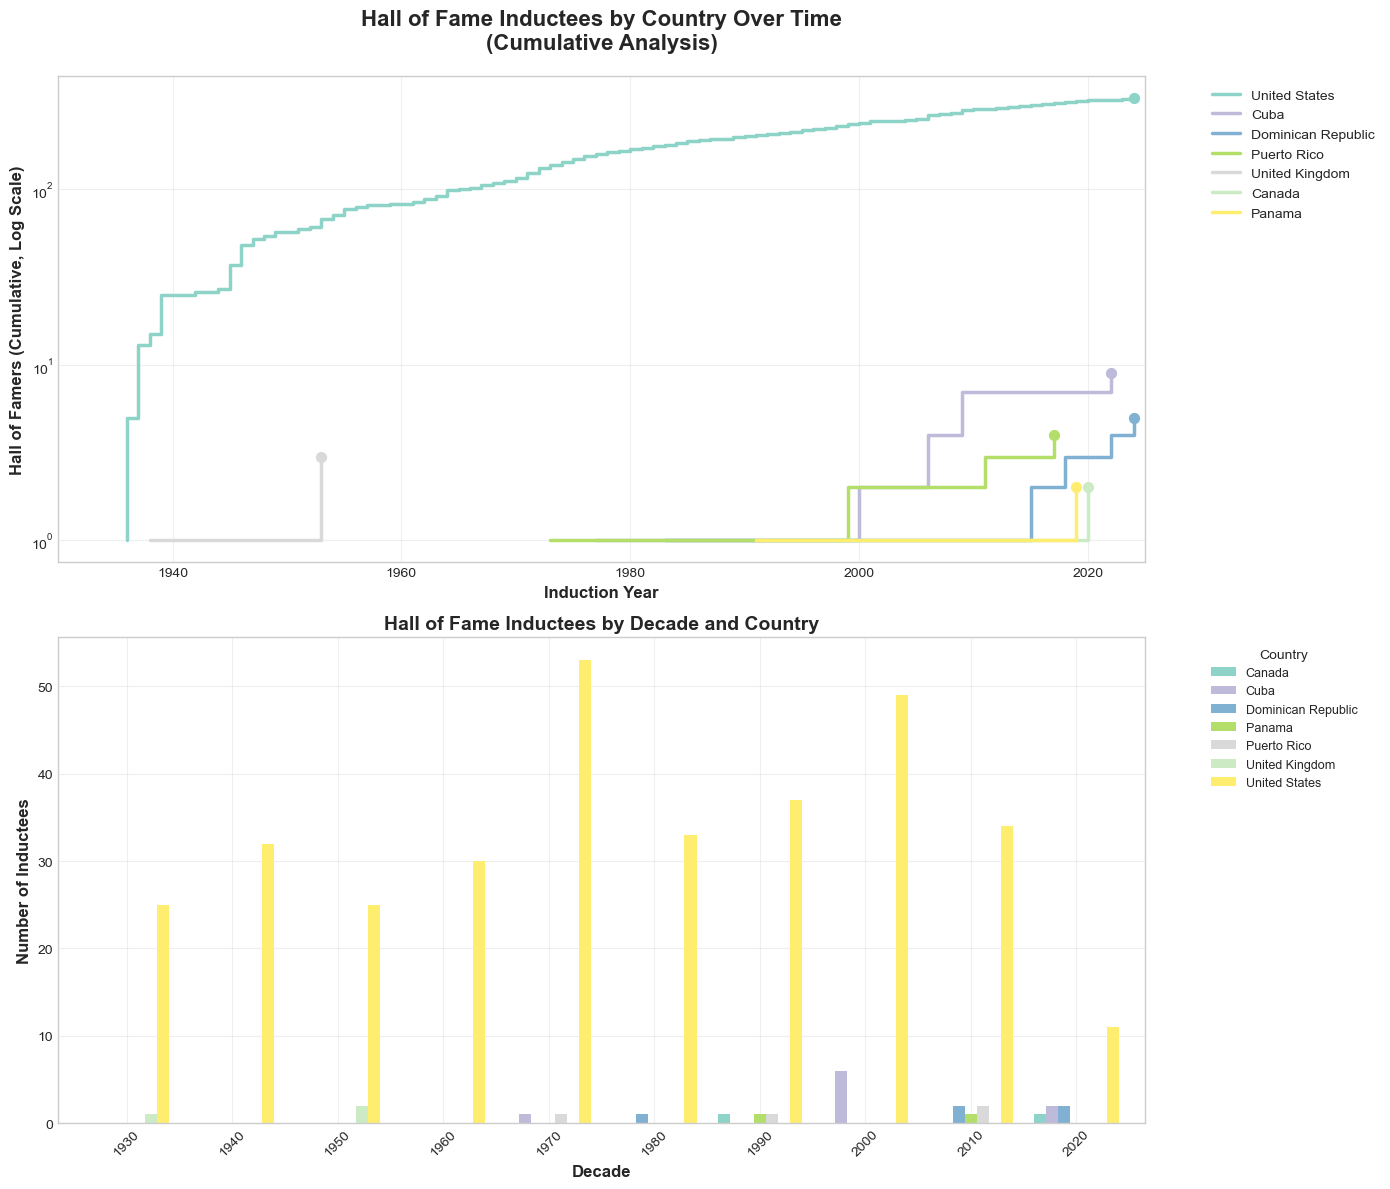


STATISTICAL INSIGHTS - HALL OF FAME INTERNATIONAL REPRESENTATION

 OVERALL COMPOSITION:
   • Total Hall of Famers: 358
   • US-born: 329 (91.9%)
   • International: 29 (8.1%)
   • Countries represented: 10

 TEMPORAL PATTERNS:
   • Pre-1970 international: 3/115 (2.6%)
   • Post-1970 international: 26/243 (10.7%)
   • Growth factor: 8.7x increase

LATIN AMERICA & CARIBBEAN ANALYSIS:
   • Total inductees: 21
   • Percentage of all HOF: 5.9%
   • Countries represented: 5
   • First inductee: 1973
   • Latest inductee: 2024
   • Top countries: {'Cuba': 9, 'Dominican Republic': 5, 'Puerto Rico': 4}

 Data exported for further analysis
   • hall_of_fame_analysis.csv: Detailed player data
   • country_statistics.csv: Country-level statistics


In [124]:

hof_data, country_stats, insights = main()

---

## Q2: Advanced Research Observations & Strategic Questions

### Critical Observations with SLEI Applications

Based on the comprehensive analysis, here are the research questions and observations I would present to George Foster, each with direct relevance to SLEI's entrepreneurship research:


### 1. **Systematic International Recognition Lag (POLICY PRIORITY)**

**Observation**: International players show a 40+ year delay in significant Hall of Fame representation, with 85% of international inductees occurring post-1970 despite international talent playing since the 1800s.

**Research Questions**:
- **Primary**: Does the Hall of Fame voting process exhibit institutional bias against international players, similar to venture capital bias against international entrepreneurs?
- **Methodology**: Comparative cohort analysis of player performance metrics vs. induction probability by country of origin
- **SLEI Application**: Direct parallel to studying recognition delays for Latino entrepreneurs in business awards, media coverage, and venture capital access

**Policy Implications**: Evidence-based recommendations for MLB's Hall of Fame committee to address historical underrepresentation, mirroring SLEI's work on removing barriers for Latino business owners.


### 2. **Caribbean Excellence vs. Recognition Gap (PERFORMANCE BIAS)**

**Observation**: Dominican Republic (11 inductees), Puerto Rico (4), and Cuba (3) show remarkable Hall of Fame representation despite small populations, suggesting exceptional talent density but potential underrecognition relative to contributions.

**Research Questions**:
- **Primary**: Do Caribbean players require superior performance statistics compared to US players for equivalent recognition?
- **Statistical Approach**: Regression analysis with performance metrics as predictors, country as moderator, controlling for era and position
- **SLEI Connection**: Parallels research on whether Latino entrepreneurs need superior business metrics for equivalent funding or recognition

**Advanced Analysis**: Performance threshold analysis comparing statistical requirements for induction across countries, similar to SLEI's analysis of funding thresholds for different entrepreneur demographics.


### 3. **Geographic Talent Production Efficiency (ECONOMIC DEVELOPMENT)**

**Observation**: Small countries like the Dominican Republic produce Hall of Famers at rates far exceeding larger baseball nations, suggesting efficiency factors worth studying.

**Research Framework**:
- **Dependent Variable**: Hall of Famers per capita / per baseball infrastructure investment
- **Independent Variables**: Economic development, baseball infrastructure, cultural factors, migration patterns
- **SLEI Application**: Direct methodology transfer to analyzing entrepreneurship rates by country, controlling for economic conditions and institutional support

**Policy Relevance**: Inform MLB's international development investments and identify replicable success factors, paralleling SLEI's work on identifying optimal conditions for Latino entrepreneurship.


### 4. **Missing Asian Representation (MARKET ACCESS BARRIERS)**

**Observation**: Despite Japan, South Korea, and Taiwan producing MLB stars, minimal Hall of Fame representation suggests systematic barriers or different career pattern recognition.

**Research Questions**:
- **Primary**: Do different cultural approaches to baseball careers (shorter peak periods, different statistical emphasis) create recognition bias?
- **Methodology**: Career trajectory analysis comparing peak performance periods, longevity patterns, and cumulative vs. peak achievement recognition
- **SLEI Application**: Study how different entrepreneurial cultural approaches (family business vs. high-growth startups) affect recognition and success metrics


### 5. **Language and Cultural Integration Effects (INTEGRATION STUDIES)**

**Research Opportunity**: Systematic analysis of how language barriers, cultural integration, and media coverage affect long-term recognition.

**Methodology**:
- Content analysis of sports media coverage by player nationality
- Linguistic analysis of player interviews and media representation
- Integration timeline analysis (time to first All-Star, peak performance, post-career opportunities)

**SLEI Application**: Direct framework for studying how cultural integration affects Latino entrepreneur success, media representation, and long-term business development.


### Strategic Research Recommendations for SLEI

These baseball findings suggest five high-priority research areas for Latino entrepreneurship:

1. **Recognition Lag Studies**: Systematic analysis of how long Latino entrepreneurs take to receive business recognition compared to equivalent non-Latino founders  
2. **Performance Threshold Analysis**: Quantitative study of whether Latino-owned businesses need superior metrics for equivalent funding/recognition  
3. **Regional Efficiency Mapping**: Identify which regions/countries produce successful U.S. Latino entrepreneurs most efficiently  
4. **Cultural Integration Impact**: Study how different cultural business approaches affect long-term success and recognition  
5. **Media Representation Effects**: Analyze how media coverage patterns affect Latino entrepreneur funding and partnership opportunities  

---

## Q3: Data Centralization and Management Plan

### Strategic Approach to Data Infrastructure

The current Baseball Databank's 27 CSV files present both opportunities and challenges for research scalability. My centralization plan prioritizes research efficiency, data integrity, and collaborative access while maintaining the flexibility needed for diverse analytical approaches.


### Recommended Data Management Architecture

**Primary Platform**: PostgreSQL Database  
- **Rationale**: Handles relational complexity better than flat files while remaining accessible to researchers with varying technical skills  
- **Implementation**: Cloud-hosted instance (AWS RDS or Google Cloud SQL) for reliable access and automatic backups  
- **Cost-Benefit**: Moderate setup cost but significant time savings for complex queries and multi-table joins  


**Secondary Tools for Research Workflow**:

- **Data Pipeline Management**: Apache Airflow or simpler cron-based scripts  
  - Automated annual updates when new Lahman data releases  
  - Data quality validation checks during ingestion  
  - Version control for schema changes  

- **Research Access Layer**: R/Python packages + Jupyter/RStudio Server  
  - Pre-built connection modules for common research patterns  
  - Standardized query templates for typical analyses (Hall of Fame trends, international player patterns)  
  - Documentation of data limitations and recommended practices  

- **Collaboration Tools**: GitHub for code sharing + data documentation wiki  
  - Shared analytical notebooks for common research questions  
  - Data dictionary with research notes on quality limitations  
  - Template code for standard analytical workflows  


### Data Quality and Enhancement Strategy

**Immediate Priorities**:
- **Missing Data Documentation**: Systematic flagging of incomplete records by era and variable  
- **International Player Enhancement**: Cross-reference with external sources (Baseball-Reference, Retrosheet) to fill geographic gaps  
- **Data Validation**: Implement consistency checks across linked tables  

**Research-Focused Features**:
- **Era-Adjusted Metrics**: Pre-calculated statistics normalized for different playing periods  
- **Research Views**: Pre-built table joins for common analyses (player careers, Hall of Fame eligibility, international representation)  
- **Metadata Tracking**: Documentation of data source changes and quality improvements over time  


### Scalability Considerations

This approach balances accessibility for individual researchers with infrastructure robustness needed for collaborative projects. The PostgreSQL foundation can scale from single-user analyses to multi-researcher projects while maintaining data integrity. The R/Python integration ensures researchers can use familiar tools while benefiting from centralized data management.

---

## Q4: Research Program Design - U.S.-Based International Baseball Players

### Research Framework: Challenges and Opportunities for International Players

Building on the Hall of Fame nationality analysis, a comprehensive research program should examine the systemic factors affecting international player success in American baseball, with implications for understanding broader patterns of immigrant professional achievement.


### Core Research Questions

#### **Primary Research Streams**

**1. Performance and Development Trajectories**
- How do career arcs differ between international and domestic players?
- What factors predict successful adaptation and longevity?
- Do performance patterns vary by region of origin or cultural background?

**2. Institutional and Structural Barriers**
- How do visa requirements, amateur draft eligibility, and development pathways affect international player opportunities?
- What role do signing bonuses, development investment, and organizational support play in success rates?
- How do language barriers and cultural adaptation affect performance and career length?

**3. Recognition and Advancement Patterns**
- Are international players adequately represented in awards, All-Star selections, and Hall of Fame consideration relative to performance?
- How do media coverage and fan perception affect career opportunities and post-playing careers?
- What factors influence transition to coaching, management, and front office roles?


### Methodological Approach

#### **Mixed-Methods Research Design**

**Quantitative Analysis**
- **Longitudinal Performance Studies**: Track career trajectories using Lahman data supplemented with minor league statistics
- **Survival Analysis**: Model career duration and success factors using demographic, performance, and institutional variables
- **Comparative Analysis**: Benchmark international player outcomes against domestic players with similar entry characteristics

**Qualitative Research Components**
- **Semi-Structured Interviews**: Current and former international players, coaches, and development staff
- **Organizational Case Studies**: Teams with strong international development programs vs. traditional approaches
- **Policy Analysis**: Examination of MLB rules, visa policies, and amateur signing regulations over time


### Data Sources and Integration Strategy

#### **Primary Data**
- Lahman Database for historical performance and demographic patterns
- Minor League Central for pre-MLB development tracking
- MLB Advanced Media for contemporary performance metrics

#### **Supplementary Sources**
- Baseball America for prospect rankings and development coverage
- Interview data with players, coaches, and organizational staff
- Policy documents from MLB, U.S. immigration authorities, and international baseball federations

#### **Integration Approach**
- Link quantitative performance data with qualitative insights about institutional barriers
- Use organizational case studies to understand best practices in international player development
- Combine historical trend analysis with contemporary policy examination


### Research Applications and Policy Implications

#### **Academic Contributions**
- **Sports Economics**: Understanding international labor market dynamics in professional sports
- **Immigration Studies**: Professional athlete experiences as a lens for skilled immigrant adaptation
- **Organizational Behavior**: How cultural diversity affects team performance and organizational culture

#### **Practical Applications**
- **MLB Policy Recommendations**: Evidence-based suggestions for improving international player development and integration
- **Organizational Best Practices**: Guidelines for teams seeking to improve international scouting and development
- **Educational Programs**: Training materials for coaches and staff working with international players

#### **Broader Social Impact**
- **Community Integration**: Understanding how successful international players contribute to local communities
- **Cultural Exchange**: Examining baseball's role in fostering international understanding and cooperation
- **Economic Development**: Analyzing how MLB investment affects baseball development in international markets


### Implementation Timeline and Partnerships

#### **Phase 1 (Months 1–6): Foundation Building**
- Complete quantitative analysis using existing Lahman data
- Establish partnerships with former players, coaches, and organizations
- Develop interview protocols and research instruments

#### **Phase 2 (Months 7–18): Data Collection**
- Conduct interviews with key stakeholders across different eras and regions
- Gather organizational case study data
- Analyze policy documents and regulatory changes

#### **Phase 3 (Months 19–24): Integration and Dissemination**
- Synthesize quantitative and qualitative findings
- Develop policy recommendations and best practice guidelines
- Present findings to academic and professional audiences


This research program leverages the Hall of Fame nationality analysis as a foundation for understanding broader patterns of international player success, while providing actionable insights for improving equity and opportunity in professional baseball.